Нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import lightgbm as lgbm
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt



In [2]:
taxi_order = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
taxi_order.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
taxi_order.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [5]:
taxi_order.tail(10)

,num_orders
datetime,
2018-08-31 22:20:00,48
2018-08-31 22:30:00,41
2018-08-31 22:40:00,34
2018-08-31 22:50:00,34
2018-08-31 23:00:00,30
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39


In [6]:
taxi_order.sort_index(inplace=True)

In [7]:
taxi_order.shape

(26496, 1)

In [8]:
taxi_order = taxi_order.resample('1H').sum()

### Загрузил данные, при открытии файла индексировал по датам, даты привел к datetime64
### Посмотрел инфо, голову и хвост
### Отсортировал по индексам и ресемплировал по 1 часу

# 2. Анализ

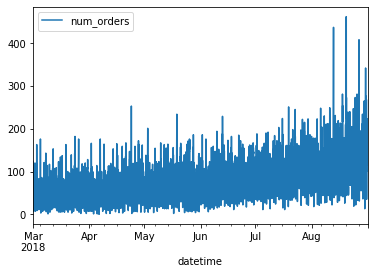

In [9]:
taxi_order.plot()

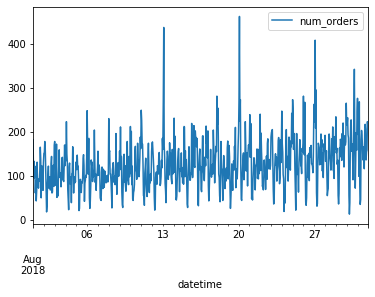

In [10]:
taxi_order['2018-08-01':'2018-08-31'].plot()

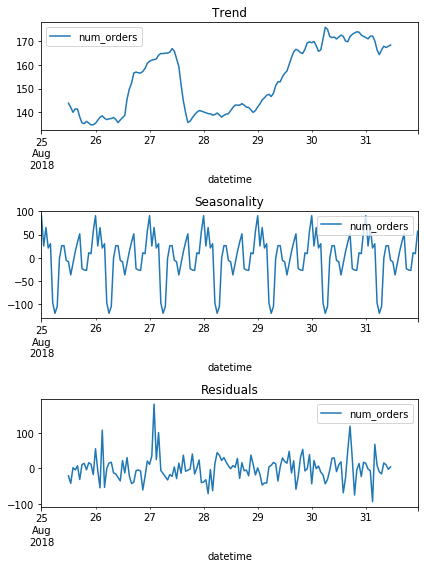

In [11]:
decomposed = seasonal_decompose(taxi_order['2018-08-25':'2018-08-31'])
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

### Разложил на trend seasonality и residuals построил граффики

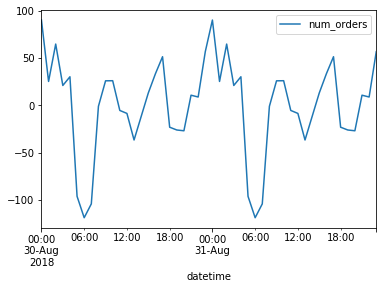

In [12]:
decomposed.seasonal['2018-08-30':'2018-08-31'].plot()

### Построил граффик сезонности на 1 день. Сдесь я вижу падение количества заказов примерно после 2 ночи до 6 утра, с 6 утра идет резкий рост когда люди едут на работу, после 12 идет небольшой спад. Далее с 16 часов до 18 рост когда люди возвращаются с работы и в конце в вечерние часы самый большой рост, связанный как я думаю с тем что общественный транспорт уже ходит хуже и такси становится наиболее оптимальным видом транспорта

# 3. Обучение

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    taxi_order['year'] = taxi_order.index.year
    taxi_order['month'] = taxi_order.index.month
    taxi_order['day'] =  taxi_order.index.day
    taxi_order['dayofweek'] = taxi_order.index.weekday
    for lag in range(1, max_lag+1):
        taxi_order['lag_{}'.format(lag)] = taxi_order['num_orders'].shift(lag)
    taxi_order['rolling_mean'] = taxi_order['num_orders'].shift(1).rolling(rolling_mean_size).mean()    
        

### С помощью функиции создал фитчи: год, месяц, день, день недели, шифт и скользящее среднее

In [14]:
#for i in range(1, 8):
#    for j in range(1, 4):
#        make_features(taxi_order, i, j)
#        taxi_order = taxi_order.dropna()
#        target = taxi_order['num_orders']
#        features = taxi_order.drop(['num_orders'], axis = 1)
##        features_train_0, valid_features, target_train_0, valid_target = train_test_split(
#            features, target, test_size = 0.2, shuffle=False)
##        train_features, test_features, train_target, test_target = train_test_split(
#            features_train_0, target_train_0, test_size = 0.13 , shuffle=False)
#        model_1 = lgbm.sklearn.LGBMRegressor(max_depth = 4, num_leaves = 35, n_estimators = 50)
#        model_1.fit(train_features, train_target)
#        predicted_1 = model_1.predict(valid_features)
#        mse = mean_squared_error(valid_target, predicted_1)
#        print(i, j,'RMSE LGBM =', mse**0.5)
        
        
        

### Для подбора оптимальных значений фунцкии make features я создал цикл перебирающий значения шифта и скользящего среднего. Результат проверял на RMSE LGBM (цикл закоментировал, результат его работы сохранил в ячейку ниже. Луший результат получился при shift = 3 и rolling mean = 2)

- 1 2 RMSE LGBM = 62.144312329023876
- 1 3 RMSE LGBM = 61.57426670781169
- 2 1 RMSE LGBM = 62.56304058765292
- 2 2 RMSE LGBM = 61.6594587364294
- 2 3 RMSE LGBM = 61.199343943294366
- 3 1 RMSE LGBM = 61.460739678827714
- 3 2 RMSE LGBM = 61.13530847438784
- 3 3 RMSE LGBM = 61.463871607562616
- 4 1 RMSE LGBM = 61.3474534495917
- 4 2 RMSE LGBM = 62.000609943504614
- 4 3 RMSE LGBM = 61.50606173185732
- 5 1 RMSE LGBM = 67.75909460692844
- 5 2 RMSE LGBM = 67.12399605023265
- 5 3 RMSE LGBM = 67.91316706250947
- 6 1 RMSE LGBM = 70.39455600337206
- 6 2 RMSE LGBM = 70.99774764886217
- 6 3 RMSE LGBM = 72.91363885078916
- 7 1 RMSE LGBM = 71.58509799843375
- 7 2 RMSE LGBM = 71.33275983994405
- 7 3 RMSE LGBM = 70.97001638572536

In [15]:
make_features(taxi_order, 3, 2)

In [16]:
taxi_order.head(10)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,104.5
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,78.0
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,68.5
2018-03-01 05:00:00,6,2018,3,1,3,43.0,66.0,71.0,54.5
2018-03-01 06:00:00,12,2018,3,1,3,6.0,43.0,66.0,24.5
2018-03-01 07:00:00,15,2018,3,1,3,12.0,6.0,43.0,9.0
2018-03-01 08:00:00,34,2018,3,1,3,15.0,12.0,6.0,13.5


In [17]:
taxi_order = taxi_order.dropna()

In [18]:
target = taxi_order['num_orders']
features = taxi_order.drop(['num_orders'], axis = 1)

In [19]:
features_train_0, valid_features, target_train_0, valid_target = train_test_split(
    features, target, test_size = 0.1, shuffle=False)
train_features, test_features, train_target, test_target = train_test_split(features_train_0, target_train_0, test_size = 0.22, shuffle=False)

### Разбил выборку на train valid and test. Test, valid примерно по 10%

In [20]:
model = LinearRegression()
model.fit(train_features, train_target)
predicted = model.predict(valid_features)

In [21]:
print("RMSE : ", (mean_squared_error(valid_target, predicted))**0.5)

RMSE :  53.5952591267944


### первая модель - линейна регрессия.

In [22]:
#for i in range(3, 9):
#    for j in range(20, 40, 5):
#        for l in range(50, 150, 10):
#            model_1 = lgbm.sklearn.LGBMRegressor(max_depth = i, num_leaves = j, n_estimators = l)
#            model_1.fit(train_features, train_target)
#            predicted_1 = model_1.predict(valid_features)
#            mse = mean_squared_error(valid_target, predicted_1)
#            print('depth', i, 'leaves', j, 'estimators', l, 'RMSE=', mse**0.5)

### Вторая модель - LGBMRegressor в циклах перебрал различные гиперпараметры, луший результат при глубине 4, 35 листях и 50 оценщиках

depth 4 leaves 35 estimators 50 RMSE= 65.5966342599486

In [23]:
model_1 = lgbm.sklearn.LGBMRegressor(max_depth = 4, num_leaves = 35, n_estimators = 50)
model_1.fit(train_features, train_target)
predicted_1 = model_1.predict(valid_features)
mse = mean_squared_error(valid_target, predicted_1)
print('RMSE LGBM =', mse**0.5)

RMSE LGBM = 60.40441192261411


# 4. Тестирование

In [24]:
predicted_3 = model.predict(test_features)
print("RMSE тестовой выборки: ", (mean_squared_error(test_target, predicted_3))**0.5)

RMSE тестовой выборки:  37.82910789283543


In [25]:
predicted_4 = model_1.predict(test_features)
mse = mean_squared_error(test_target, predicted_4)
print('RMSE LGBM Test =', mse**0.5)

RMSE LGBM Test = 38.786298439018346


### Проверяю модели на тестевой выборке.
### Обе модели показали примерно одинаковый результат, около 38 rmse, но линейная регрессия показала даже лучше результат чем бустинг, скорее всего для временных рядов это наиболее оптимальная модель.

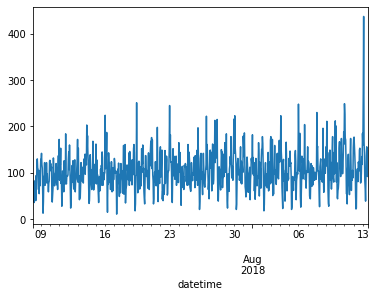

In [26]:
test_target.plot()

In [27]:
test_target = pd.DataFrame(test_target)

In [28]:
test_target['predicted_lgbm'] = predicted_4

In [29]:
test_target['predicted_linear'] = predicted_3

In [30]:
test_target.head()

,num_orders,predicted_lgbm,predicted_linear
datetime,,,
2018-07-08 04:00:00,82,118.926748,137.076147
2018-07-08 05:00:00,73,114.853286,92.929272
2018-07-08 06:00:00,44,82.920184,75.038364
2018-07-08 07:00:00,36,76.724721,68.819805
2018-07-08 08:00:00,80,63.981674,63.673883


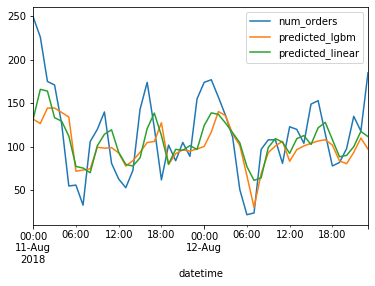

In [31]:
test_target['2018-08-11':'2018-08-12'].plot()

### Создал и тестевого таргета ДФ, туда добавил предсказания обоих моделей.
### На графике видно что линейная регрессия лучше предсказывает пики, там где они должны быть у бустинга просто плавный переход. Единстенное бустинг точно определил нижнюю точку около 6.00